# 4. Tentative application to real data produced by a synthetic sample

This code generates all the results presented in the section of application to real data.

### License

This code is licensed under under the [BSD 3-clause](http://choosealicense.com/licenses/bsd-3-clause/) license. See the file `LICENSE.md`

### Import the required dependencies

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from IPython.display import Image
from fatiando.vis import mpl, myv

In [3]:
mpl.rcParams['font.size'] = 16

In [4]:
import functions as f

### Load data from txt files

In [5]:
files = ['..\\data\\data0.txt', 
         '..\\data\\data1.txt',
         '..\\data\\data2.txt',
         '..\\data\\data3.txt']

nfiles = len(files)

In [6]:
data = []

for i in range(nfiles):
    data.append(np.loadtxt(files[i]))

### Parameters of the sample

In [7]:
P = 16 # number of prisms forming the sample
M = 3*P # number of parameters to be estimated

Lx = 0.001 # in m
Ly = 0.003 # in m
Lz = Ly  # in m

shape = (42,102)
#shape = (102,42)

In [8]:
xmin_sample = -0.5*Lx*P #in m
centers = [100.*(xmin_sample + 0.5*Lx + i*Lx) for i in range(P)] #in cm
centers = np.array(centers)

### Interpretation model

In [9]:
model = f.sample(Lx,Ly,Lz,P)

In [10]:
xmin = np.min([data[0][:,0], data[1][:,0], data[2][:,0], data[3][:,0]])
xmax = np.max([data[0][:,0], data[1][:,0], data[2][:,0], data[3][:,0]])
ymin = np.min([data[0][:,1], data[1][:,1], data[2][:,1], data[3][:,1]])
ymax = np.max([data[0][:,1], data[1][:,1], data[2][:,1], data[3][:,1]])
zmin = np.min([data[0][:,2], data[1][:,2], data[2][:,2], data[3][:,2]])
zmax = np.max([data[0][:,2], data[1][:,2], data[2][:,2], data[3][:,2]])

volume = [xmin, xmax, ymin, ymax, zmin, zmax]

### Inversion

In [11]:
B_obs = []
for i in range(4):
    B_obs.append(data[i][:,3])

In [12]:
A = []
for i in range(4):
    A.append(f.sensitivity(P, data[i][:,0], data[i][:,1], data[i][:,2], model,i, eff_area=(300.,300.)))

In [13]:
R = np.zeros(M+1)
R[0] = 1.
R[3] = -1.
R = np.resize(R, (M-3,M))

In [14]:
u0 = [1.0e-10 for i in range(4)]
f0 = []
p_est = []
mag_r = []

H = np.dot(A[0].T, A[0])
if u0[0] != 0.:
    f0.append(np.trace(H)/M)
    H = H + u0[0]*f0[0]*np.dot(R.T, R)
h = np.dot(A[0].T, B_obs[0])
p_est.append(np.linalg.solve(H, h))
mag_r.append(f.parameters_sph(P,p_est[0]))

for i in range(1,4):
    H = np.dot(np.vstack(A[:i]).T, np.vstack(A[:i]))
    if u0[i] != 0.:
        f0.append(np.trace(H)/M)
        H = H + u0[i]*f0[i]*np.dot(R.T, R)
    h = np.dot(np.vstack(A[:i]).T, np.hstack(B_obs[:i]))
    p_est.append(np.linalg.solve(H, h))
    mag_r.append(f.parameters_sph(P,p_est[i]))

mag_r = np.array(mag_r)

In [16]:
np.savetxt('..\\data\\estimate_real.txt', np.array(mag_r[3]), fmt='%.5f')

In [17]:
B_pre = []
for i in range(4):
    B_pre.append(np.dot(A[i],p_est[3]))

In [18]:
r_norm = []
r_mean = []
r_std = []

for i in range(4):
    aux1,aux2,aux3 = f.residual(0.001*B_obs[i],0.001*B_pre[i])
    r_norm.append(aux1) # in uT
    r_mean.append(aux2) # in uT
    r_std.append(aux3)  # in uT

### Plotting of the observed and predicted data 

C:\Anaconda2\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


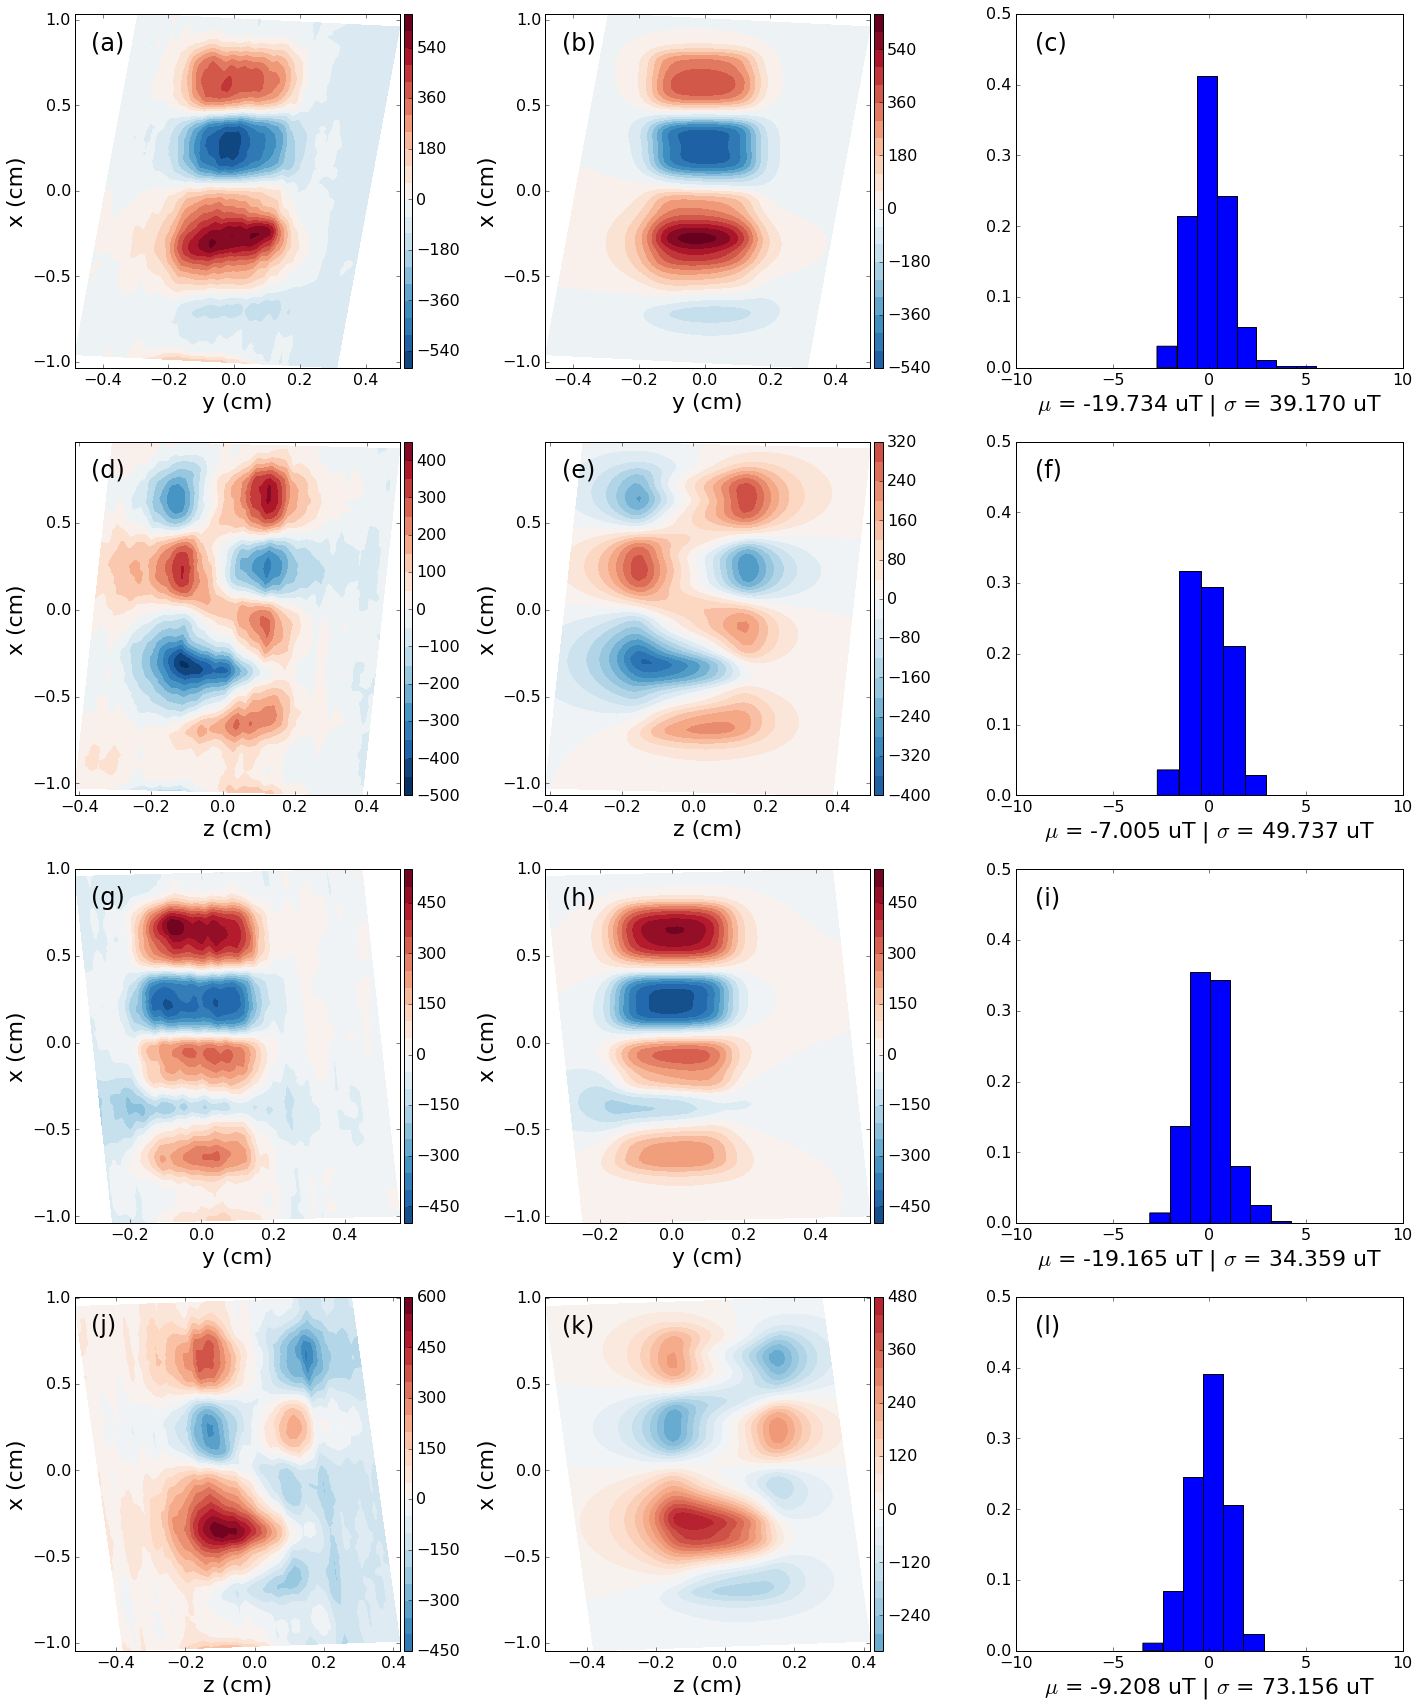

In [19]:
title_font = 22
bottom_font = 16

labels = ['(a)', '(b)', '(c)', 
          '(d)', '(e)', '(f)',
          '(g)', '(h)', '(i)',
          '(j)', '(k)', '(l)']

lables_place = (0.05, 0.90)
lables_size = 24

mpl.close('all')
mpl.figure(figsize=(20,24), tight_layout=True)

for i in range(0,4,2):

    # in uT
    ranges = 0.001*np.abs([B_obs[i].max(), B_obs[i].min(),
                           B_pre[i].max(), B_pre[i].min()]).max()

    mpl.subplot(4,3,1 + 3*i)

    #mpl.title(labels[3*i], fontsize=title_font)
    nlevels = mpl.contourf(100.*data[i][:,1], 100.*data[i][:,0], 0.001*B_obs[i], 
                           shape, 20, cmap=mpl.cm.RdBu_r,
                           vmin=-ranges, vmax=ranges)
    #mpl.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('uT')
    mpl.colorbar(pad=0.01, aspect=40, shrink=1.0)
    mpl.xlabel('y (cm)', fontsize = title_font)
    mpl.ylabel('x (cm)', fontsize = title_font)
    mpl.annotate(labels[3*i], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

    mpl.subplot(4,3,1 + 3*i + 1)

    #mpl.title(labels[3*i + 1], fontsize=title_font)
    nlevels = mpl.contourf(100.*data[i][:,1], 100.*data[i][:,0], 0.001*B_pre[i], 
                           shape, 20, cmap=mpl.cm.RdBu_r,
                           vmin=-ranges, vmax=ranges)
    #mpl.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('uT')
    mpl.colorbar(pad=0.01, aspect=40, shrink=1.0)
    mpl.xlabel('y (cm)', fontsize = title_font)
    mpl.ylabel('x (cm)', fontsize = title_font)
    mpl.annotate(labels[3*i + 1], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

    mpl.subplot(4,3,1 + 3*i + 2)
    #mpl.title(labels[3*i + 2], fontsize=title_font)
    mpl.xlabel('$\mu$ = %.3f uT | $\sigma$ = %.3f uT' % (r_mean[i], r_std[i]), fontsize = title_font)
    nbins = int((np.max(r_norm[i]) - np.min(r_norm[i])))
    mpl.hist(r_norm[i],bins=nbins,normed=True)
    mpl.ylim(0.,0.5)
    mpl.xlim(-10., 10.)
    mpl.annotate(labels[3*i + 2], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)
    
for i in range(1,4,2):

    # in uT
    ranges = 0.001*np.abs([B_obs[i].max(), B_obs[i].min(),
                           B_pre[i].max(), B_pre[i].min()]).max()

    mpl.subplot(4,3,1 + 3*i)

    #mpl.title(labels[3*i], fontsize=title_font)
    nlevels = mpl.contourf(100.*data[i][:,2], 100.*data[i][:,0], 0.001*B_obs[i], 
                           shape, 20, cmap=mpl.cm.RdBu_r,
                           vmin=-ranges, vmax=ranges)
    #mpl.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('uT')
    mpl.colorbar(pad=0.01, aspect=40, shrink=1.0)
    mpl.xlabel('z (cm)', fontsize = title_font)
    mpl.ylabel('x (cm)', fontsize = title_font)
    mpl.annotate(labels[3*i], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

    mpl.subplot(4,3,1 + 3*i + 1)

    #mpl.title(labels[3*i + 1], fontsize=title_font)
    nlevels = mpl.contourf(100.*data[i][:,2], 100.*data[i][:,0], 0.001*B_pre[i], 
                           shape, 20, cmap=mpl.cm.RdBu_r,
                           vmin=-ranges, vmax=ranges)
    #mpl.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('uT')
    mpl.colorbar(pad=0.01, aspect=40, shrink=1.0)
    mpl.xlabel('z (cm)', fontsize = title_font)
    mpl.ylabel('x (cm)', fontsize = title_font)
    mpl.annotate(labels[3*i+1], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

    mpl.subplot(4,3,1 + 3*i + 2)
    #mpl.title(labels[3*i + 2], fontsize=title_font)
    mpl.xlabel('$\mu$ = %.3f uT | $\sigma$ = %.3f uT' % (r_mean[i], r_std[i]), fontsize = title_font)
    nbins = int((np.max(r_norm[i]) - np.min(r_norm[i])))
    mpl.hist(r_norm[i],bins=nbins,normed=True)
    mpl.ylim(0.,0.5)
    mpl.xlim(-10., 10.)
    mpl.annotate(labels[3*i+2], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)

mpl.savefig('..\\manuscript\\Figs\\Fig14_LQ.png')
mpl.savefig('..\\manuscript\\Figs\\Fig14_HQ.eps')

mpl.show()

In [20]:
non_spurious = np.array([True for i in range(P)])
non_spurious[::4] = False

spurious = np.array([False for i in range(P)])
spurious[::4] = True

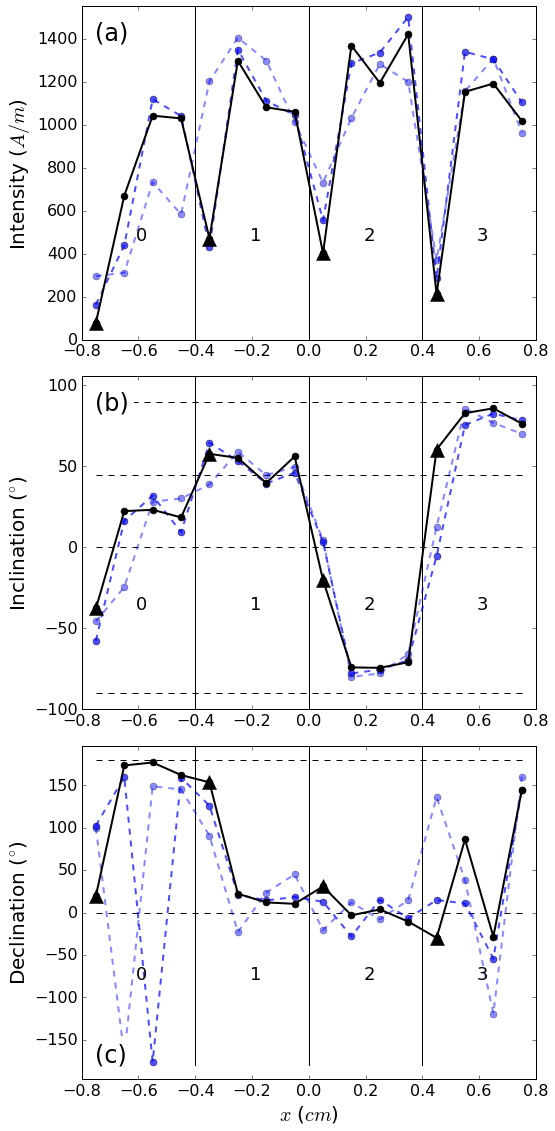

In [31]:
line_sty = ['b--', 'b--', 'b--', 'k-']
mark_sty = ['bo', 'bo', 'bo', 'ko']
#mark_sty_spu = ['b^', 'b^', 'b^', 'k^']

label_font = 20
legend_font = 16

labels = ['(a)', '(b)', '(c)']

lables_place = (0.03, 0.90)
lables_size = 24

mpl.show()
mpl.close('all')
mpl.figure(figsize=(8, 16), tight_layout=True)

mpl.subplot(3,1,1)
mpl.plot([-400.*Lx, -400.*Lx], [0., 1800.0], 'k-')
mpl.plot([0., 0.], [0., 1800.0], 'k-')
mpl.plot([400.*Lx, 400.*Lx], [0., 1800.0], 'k-')
mpl.plot([np.min(centers), np.max(centers)], [0.0, 0.0], 'k--')

for i, mr in enumerate(mag_r):
    mpl.plot(centers, mr[:,0], line_sty[i], alpha=0.1+i*0.3, linewidth=2)
    mpl.plot(centers, mr[:,0], mark_sty[i], alpha=0.1+i*0.3, markersize=7)
mpl.plot(centers[spurious], mag_r[3,spurious,0], 'k^', alpha=0.1+i*0.3, markersize=14)
    
#mpl.plot(centers, mag_r[:,0], 'b--', linewidth=2)
#mpl.plot(centers[non_spurious], mag_r[non_spurious,0], 'bo', markersize=10)
#mpl.plot(centers[spurious], mag_r[spurious,0], 'k^', markersize=12)

mpl.ylabel('Intensity ($A/m$)', fontsize=label_font)
mpl.ylim(0., np.max(mag_r[:,:,0]) + 50.)
mpl.annotate(labels[0], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size)
mpl.annotate('0', xy = (0.12, 0.3), 
                 xycoords = 'axes fraction', fontsize=18)
mpl.annotate('1', xy = (0.37, 0.3), 
                 xycoords = 'axes fraction', fontsize=18)
mpl.annotate('2', xy = (0.62, 0.3), 
                 xycoords = 'axes fraction', fontsize=18)
mpl.annotate('3', xy = (0.87, 0.3), 
                 xycoords = 'axes fraction', fontsize=18)

mpl.subplot(3,1,2)
mpl.plot([-400.*Lx, -400.*Lx], [-180., 180.0], 'k-')
mpl.plot([0., 0.], [-180., 180.0], 'k-')
mpl.plot([400.*Lx, 400.*Lx], [-180., 180.0], 'k-')
mpl.plot([np.min(centers), np.max(centers)], [0.0, 0.0], 'k--')
mpl.plot([np.min(centers), np.max(centers)], [45.0, 45.0], 'k--')
mpl.plot([np.min(centers), np.max(centers)], [-90.0, -90.0], 'k--')
mpl.plot([np.min(centers), np.max(centers)], [90.0, 90.0], 'k--')

for i, mr in enumerate(mag_r):
    mpl.plot(centers, mr[:,1], line_sty[i], alpha=0.1+i*0.3, linewidth=2)
    mpl.plot(centers, mr[:,1], mark_sty[i], alpha=0.1+i*0.3, markersize=7)
mpl.plot(centers[spurious], mag_r[3,spurious,1], 'k^', alpha=0.1+i*0.3, markersize=14)

#mpl.plot(centers, mag_r[:,1], 'b--', linewidth=2)
#mpl.plot(centers[non_spurious], mag_r[non_spurious,1], 'bo', markersize=10)
#mpl.plot(centers[spurious], mag_r[spurious,1], 'k^', markersize=12)

mpl.ylabel('Inclination ($^{\circ}$)', fontsize=label_font)
mpl.ylim(np.min(mag_r[:,:,1]) - 20., np.max(mag_r[:,:,1]) + 20.)
mpl.annotate(labels[1], xy = lables_place, 
                 xycoords = 'axes fraction', fontsize=lables_size,
                 backgroundcolor = 'w')
mpl.annotate('0', xy = (0.12, 0.3), 
                 xycoords = 'axes fraction', fontsize=18)
mpl.annotate('1', xy = (0.37, 0.3), 
                 xycoords = 'axes fraction', fontsize=18)
mpl.annotate('2', xy = (0.62, 0.3), 
                 xycoords = 'axes fraction', fontsize=18)
mpl.annotate('3', xy = (0.87, 0.3), 
                 xycoords = 'axes fraction', fontsize=18)

mpl.subplot(3,1,3)
mpl.plot([-400.*Lx, -400.*Lx], [-180., 200.0], 'k-')
mpl.plot([0., 0.], [-180., 200.0], 'k-')
mpl.plot([400.*Lx, 400.*Lx], [-180., 200.0], 'k-')
mpl.plot([np.min(centers), np.max(centers)], [0.0, 0.0], 'k--')
mpl.plot([np.min(centers), np.max(centers)], [180.0, 180.0], 'k--')

for i, mr in enumerate(mag_r):
    mpl.plot(centers, mr[:,2], line_sty[i], alpha=0.1+i*0.3, linewidth=2)
    mpl.plot(centers, mr[:,2], mark_sty[i], alpha=0.1+i*0.3, markersize=7)
mpl.plot(centers[spurious], mag_r[3,spurious,2], 'k^', alpha=0.1+i*0.3, markersize=14)

#mpl.plot(centers, mag_r[:,2], 'b--', linewidth=2)
#mpl.plot(centers[non_spurious], mag_r[non_spurious,2], 'bo', markersize=10)
#mpl.plot(centers[spurious], mag_r[spurious,2], 'k^', markersize=12)

mpl.ylabel('Declination ($^{\circ}$)', fontsize=label_font)
#mpl.xlabel('Sample length ($cm$)', fontsize=label_font)
mpl.xlabel('$x$ ($cm$)', fontsize=label_font)
mpl.ylim(np.min(mag_r[:,:,2]) - 20., np.max(mag_r[:,:,2]) + 20.)
#mpl.savefig('estimate_int_inc_dec_simul_validation.eps')
#mpl.legend(loc='best', numpoints=1)
mpl.annotate(labels[2], xy = (0.03, 0.05), 
                 xycoords = 'axes fraction', fontsize=lables_size,
                 backgroundcolor = 'w')
mpl.annotate('0', xy = (0.12, 0.3), 
                 xycoords = 'axes fraction', fontsize=18)
mpl.annotate('1', xy = (0.37, 0.3), 
                 xycoords = 'axes fraction', fontsize=18)
mpl.annotate('2', xy = (0.62, 0.3), 
                 xycoords = 'axes fraction', fontsize=18)
mpl.annotate('3', xy = (0.87, 0.3), 
                 xycoords = 'axes fraction', fontsize=18)

mpl.savefig('..\\manuscript\\Figs\\Fig15_LQ.png')
mpl.savefig('..\\manuscript\\Figs\\Fig15_HQ.eps')

mpl.show()

### Discussion

The synthetic sample is formed by four justaposed cubes along the x diretion. The interpretation model used in this simulation is formed by 16 prisms, so that each cube of the original synthetic sample is described by four prisms. 